In [ ]:
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, linear_model, model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sn
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score


# Introduction

In this project we will analyze the sales data of a vehicle company.
The analysis contains four parts:
1. Organizing and cleaning the data (if needed), using EDA analysis.
2. Finding out basic info about the sales (top sales by country, year, month and cetera).
3. Customer segmentation using RFM analysis.
4. Sales forecasting for each product line for the next 7 days.

# Part 1 - Organizing and cleaning the data

In [ ]:
raw_data = pd.read_csv('sales_data_sample.csv')

raw_data['ORDERDATE'] = pd.to_datetime(raw_data['ORDERDATE'])

raw_data.duplicated(keep='first').sum()

# North America territory originally appeared as 'NA', thus 'null', so I changed it.
raw_data['TERRITORY'] = raw_data['TERRITORY'].fillna('North America')

Explore the data

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ORDERNUMBER       2823 non-null   int64         
 1   QUANTITYORDERED   2823 non-null   int64         
 2   PRICEEACH         2823 non-null   float64       
 3   ORDERLINENUMBER   2823 non-null   int64         
 4   SALES             2823 non-null   float64       
 5   ORDERDATE         2823 non-null   datetime64[ns]
 6   STATUS            2823 non-null   object        
 7   QTR_ID            2823 non-null   int64         
 8   MONTH_ID          2823 non-null   int64         
 9   YEAR_ID           2823 non-null   int64         
 10  PRODUCTLINE       2823 non-null   object        
 11  MSRP              2823 non-null   int64         
 12  PRODUCTCODE       2823 non-null   object        
 13  CUSTOMERNAME      2823 non-null   object        
 14  PHONE             2823 n

In [ ]:
raw_data.describe()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP
count,2823.000000,2823.000000,2823.000000,2823.000000,2823.000000,2823.000000,2823.000000,2823.00000,2823.000000
mean,10258.725115,35.092809,83.658544,6.466171,3553.889072,2.717676,7.092455,2003.81509,100.715551
std,92.085478,9.741443,20.174277,4.225841,1841.865106,1.203878,3.656633,0.69967,40.187912
min,10100.000000,6.000000,26.880000,1.000000,482.130000,1.000000,1.000000,2003.00000,33.000000
25%,10180.000000,27.000000,68.860000,3.000000,2203.430000,2.000000,4.000000,2003.00000,68.000000
50%,10262.000000,35.000000,95.700000,6.000000,3184.800000,3.000000,8.000000,2004.00000,99.000000
75%,10333.500000,43.000000,100.000000,9.000000,4508.000000,4.000000,11.000000,2004.00000,124.000000
max,10425.000000,97.000000,100.000000,18.000000,14082.800000,4.000000,12.000000,2005.00000,214.000000


In [ ]:
raw_data.isnull().sum()

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2521
CITY                   0
STATE               1486
POSTALCODE            76
COUNTRY                0
TERRITORY              0
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

In [ ]:
raw_data.duplicated().sum()

0

Our data looks fine! let's continue

# EDA analysis

Finding outliers:

In [ ]:
eda_df = raw_data.copy()
labelencoder = LabelEncoder()

#convert all columns to int
for col in eda_df.columns:
    if eda_df[col].dtype == object:
        eda_df.loc[:, col] = labelencoder.fit_transform(eda_df.loc[:,col].astype(str))

float_col = ['PRICEEACH', 'SALES']
for f_col in float_col:
    eda_df[f_col] = eda_df[f_col].astype(np.int64)

eda_df.drop(['ORDERDATE'], axis = 1, inplace = True)
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ORDERNUMBER       2823 non-null   int64
 1   QUANTITYORDERED   2823 non-null   int64
 2   PRICEEACH         2823 non-null   int64
 3   ORDERLINENUMBER   2823 non-null   int64
 4   SALES             2823 non-null   int64
 5   STATUS            2823 non-null   int32
 6   QTR_ID            2823 non-null   int64
 7   MONTH_ID          2823 non-null   int64
 8   YEAR_ID           2823 non-null   int64
 9   PRODUCTLINE       2823 non-null   int32
 10  MSRP              2823 non-null   int64
 11  PRODUCTCODE       2823 non-null   int32
 12  CUSTOMERNAME      2823 non-null   int32
 13  PHONE             2823 non-null   int32
 14  ADDRESSLINE1      2823 non-null   int32
 15  ADDRESSLINE2      2823 non-null   int32
 16  CITY              2823 non-null   int32
 17  STATE             2823 non-null  

In [ ]:

all_outlier_rows = []
for col in eda_df.columns:        
        Q1 = np.percentile(eda_df[col], 25)
        Q3 = np.percentile(eda_df[col], 75)
        IQR = Q3 - Q1
        IQR_range = 1.5 * IQR
        col_outlier = eda_df[(eda_df[col] < Q1 - IQR_range) | 
                              (eda_df[col] > Q3 + IQR_range )].index
        all_outlier_rows.extend(col_outlier)

outlier_data = (len(all_outlier_rows)) / len(eda_df)
print(str(outlier_data)+ ' of the data is outlired')

0.22139567835635848 of the data is outlired


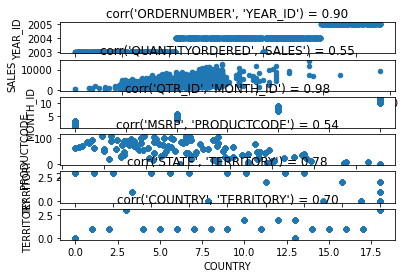

In [ ]:
def get_highly_correlated_cols(df):
    cor_matrix = df.corr().abs()
    a = []
    pairs = []
    for col in cor_matrix:
        a.append(cor_matrix[(cor_matrix[col] > 0.5)].index)
    for i in a:
        if len(i)==2:
            pairs.append(i.values)
    correlations = []
    tuple_arr = []
    for pair in pairs:
        correlations.append(cor_matrix.loc[pair[0], pair[1]])
        tuple_arr.append((df.columns.get_loc(pair[0]), df.columns.get_loc(pair[1])))
    
    correlations = list(dict.fromkeys(correlations))
    tuple_arr = list(dict.fromkeys(tuple_arr))
    return correlations, tuple_arr

get_highly_correlated_cols(eda_df)

def plot_high_correlated_scatters(df):
    tuple_arr = get_highly_correlated_cols(df)[1]
    correlations = get_highly_correlated_cols(df)[0]
    figure, axes = plt.subplots(len(tuple_arr),1)
    #figure.tight_layout(pad=2.0)
    for tup in tuple_arr:
        col1_num = tup[0]
        col2_num = tup[1]
        col_name_lt = df.columns[col1_num]
        col_name_rt = df.columns[col2_num]
        plot_title = "corr('%s', '%s') = %4.2f" %(col_name_lt, col_name_rt, correlations[tuple_arr.index(tup)])
        df.plot(x=col1_num, y=col2_num, kind = 'scatter', ax = axes[tuple_arr.index(tup)], title=plot_title)

plot_high_correlated_scatters(eda_df)

We can see that there is high correlation between sales and the quantity that was ordered, which makes sense. 


# Part 2 - Finding out the basics

LET'S FIND OUT THE BASICS:
How many products do we have? How many clients do we have? In how many countries do we sell?

In [ ]:
print(raw_data['PRODUCTCODE'].nunique())

print(raw_data['CUSTOMERNAME'].nunique())

print(raw_data['COUNTRY'].nunique())

109
92
19


# Where did we do best?



Top saled products:

In [ ]:

top_product = raw_data.groupby(['PRODUCTCODE', 'PRODUCTLINE']).sum().sort_values('SALES', ascending=False).head(11)
top_product = top_product['SALES'].round(3)
top_product.head(11)

PRODUCTCODE  PRODUCTLINE     
S18_3232     Classic Cars        288245.42
S10_1949     Classic Cars        191073.03
S10_4698     Motorcycles         170401.07
S12_1108     Classic Cars        168585.32
S18_2238     Classic Cars        154623.95
S12_3891     Classic Cars        145332.04
S24_3856     Classic Cars        140626.90
S12_2823     Motorcycles         140006.16
S18_1662     Planes              139421.97
S12_1099     Classic Cars        137177.01
S12_1666     Trucks and Buses    136692.72
Name: SALES, dtype: float64

Top sales countries:

In [ ]:
# top countries:
top_country = raw_data.groupby(['COUNTRY']).sum().sort_values('SALES', ascending=False).head(11)
top_country = top_country['SALES'].round(3)
top_country.head(11)

COUNTRY
USA          3627982.83
Spain        1215686.92
France       1110916.52
Australia     630623.10
UK            478880.46
Italy         374674.31
Finland       329581.91
Norway        307463.70
Singapore     288488.41
Denmark       245637.15
Canada        224078.56
Name: SALES, dtype: float64

Top sales cities:

In [ ]:
top_city = raw_data.groupby(['CITY']).sum().sort_values('SALES', ascending=False).head(11)
top_city = top_city['SALES'].round(3)
top_city.head(11)

CITY
Madrid           1082551.44
San Rafael        654858.06
NYC               560787.77
Singapore         288488.41
Paris             268944.68
San Francisco     224358.68
New Bedford       207874.86
Nantes            204304.86
Melbourne         200995.41
Brickhaven        165255.20
San Jose          160010.27
Name: SALES, dtype: float64

Top sales monthes:

In [ ]:
#we count only the years of 2003-2004 because we only have data about 2005 until May
month_sales = raw_data[raw_data['YEAR_ID'] < 2005]
month_sales = month_sales.groupby(['MONTH_ID']).sum().sort_values('SALES', ascending=False)
month_sales = month_sales[['SALES']].round(3)
month_sales

,SALES
MONTH_ID,
11,2118885.67
10,1121215.22
8,659310.57
12,634679.12
9,584724.27
7,514875.97
5,466111.50
6,454756.78
2,452255.72


Top products sold by quantity:


In [ ]:
product_quantity = raw_data.groupby(['PRODUCTLINE'])['QUANTITYORDERED'].sum().sort_values(ascending=False)
product_quantity

PRODUCTLINE
Classic Cars        33992
Vintage Cars        21069
Motorcycles         11663
Trucks and Buses    10777
Planes              10727
Ships                8127
Trains               2712
Name: QUANTITYORDERED, dtype: int64

# Part 3 - Customer segmentation using RFM analysis:

RFM analysis is a marketing technique used to quantitatively rank and group customers based on the recency, frequency and monetary total of their recent transactions to identify the best customers and perform targeted marketing campaigns. 

Whales -The biggest customers with high (5,5,5) values in all three factors that should be targeted with special promotions to keep them active.

New customers - Customers with high recency and low frequency (5,1,X) are new customers. A targeted follow-up may convert them into repeat customers.

Lapsed customers - Customers with low recency but high value (1,X,5) were once valuable customers but have since stopped. A targeted message may reactivate them.

In [ ]:
rfm_data = raw_data[['CUSTOMERNAME', 'ORDERNUMBER', 'ORDERDATE', 'SALES']]

# recency:
recent_date = rfm_data.groupby('CUSTOMERNAME')['ORDERDATE'].max()

# find the latest date in the table
latest_date = raw_data['ORDERDATE'].max()


def subtract_date(date):
    difference = (latest_date - date).days
    return difference


recency = recent_date.apply(subtract_date)

# frequency:

frequency = rfm_data.groupby(['CUSTOMERNAME', 'ORDERNUMBER']).size()
frequency = frequency.groupby('CUSTOMERNAME').size()

# monetary:

monetary = rfm_data.groupby('CUSTOMERNAME')['SALES'].sum()

rfm_table = pd.DataFrame()

# create columns for each df series
rfm_table['recency'] = recency
rfm_table['frequency'] = frequency
rfm_table['monetary'] = monetary

# divide each criteria to a level:

quantile_rfm = rfm_table.quantile(q=[0.25, 0.50, 0.75])


def quantile_classes(x, quantile_values, attribute):
    # recency
    if attribute == 'recency':
        if x <= quantile_values.loc[0.25, attribute]:
            return 4
        elif quantile_values.loc[0.25, attribute] <= x <= quantile_values.loc[0.50, attribute]:
            return 3
        elif quantile_values.loc[0.50, attribute] <= x <= quantile_values.loc[0.75, attribute]:
            return 2
        else:
            return 1
    else:
        if x <= quantile_values.loc[0.25, attribute]:
            return 1
        elif quantile_values.loc[0.25, attribute] <= x <= quantile_values.loc[0.50, attribute]:
            return 2
        elif quantile_values.loc[0.50, attribute] <= x <= quantile_values.loc[0.75, attribute]:
            return 3
        else:
            return 4


rfm_table['r_class'] = rfm_table['recency'].apply(quantile_classes, args=(quantile_rfm, 'recency'))
rfm_table['f_class'] = rfm_table['frequency'].apply(quantile_classes, args=(quantile_rfm, 'frequency'))
rfm_table['m_class'] = rfm_table['monetary'].apply(quantile_classes, args=(quantile_rfm, 'monetary'))

conditions = [(rfm_table['r_class'] == 4) & (rfm_table['f_class'] == 4) & (rfm_table['m_class'] == 4),
              (rfm_table['r_class'] == 4) & (rfm_table['f_class'] == 1), (rfm_table['r_class'] < 3) & (
                      rfm_table['m_class'] == 4)]

values = ['whale', 'new', 'laps']

rfm_table['costumer_type'] = np.select(conditions, values)

print(rfm_table)

                             recency  frequency   monetary  r_class  f_class  \
CUSTOMERNAME                                                                   
AV Stores, Co.                   195          3  157807.81        2        2   
Alpha Cognac                      64          3   70488.44        4        2   
Amica Models & Co.               264          2   94117.26        1        1   
Anna's Decorations, Ltd           83          4  153996.13        3        4   
Atelier graphique                187          3   24179.96        2        2   
...                              ...        ...        ...      ...      ...   
Vida Sport, Ltd                  274          2  117713.56        1        1   
Vitachrome Inc.                  207          3   88041.26        2        2   
Volvo Model Replicas, Co         193          4   75754.88        2        4   
West Coast Collectables Co.      488          2   46084.64        1        1   
giftsbymail.co.uk                211    

In [ ]:
laps_costumers = rfm_table[rfm_table['costumer_type'] == 'laps']
laps_costumers


,recency,frequency,monetary,r_class,f_class,m_class,costumer_type
CUSTOMERNAME,,,,,,,
"AV Stores, Co.",195,3,157807.81,2,2,4,laps
"Corrida Auto Replicas, Ltd",211,3,120615.28,2,2,4,laps
Land of Toys Inc.,197,4,164069.44,2,4,4,laps
Online Diecast Creations Co.,208,3,131685.30,2,2,4,laps
Rovelli Gifts,200,3,137955.72,2,2,4,laps
"Saveley & Henriot, Co.",455,3,142874.25,1,2,4,laps


In [ ]:
whale_costumers = rfm_table[rfm_table['costumer_type'] == 'whale']
whale_costumers


,recency,frequency,monetary,r_class,f_class,m_class,costumer_type
CUSTOMERNAME,,,,,,,
Danish Wholesale Imports,46,5,145041.60,4,4,4,whale
Diecast Classics Inc.,1,4,122138.14,4,4,4,whale
Euro Shopping Channel,0,26,912294.11,4,4,4,whale
La Rochelle Gifts,0,4,180124.90,4,4,4,whale
Mini Gifts Distributors Ltd.,2,17,654858.06,4,4,4,whale
Reims Collectables,62,5,135042.94,4,4,4,whale
Salzburg Collectables,14,4,149798.63,4,4,4,whale
Souveniers And Things Co.,2,4,151570.98,4,4,4,whale
The Sharp Gifts Warehouse,39,4,160010.27,4,4,4,whale


In [ ]:
new_costumers = rfm_table[rfm_table['costumer_type'] == 'new']
new_costumers

,recency,frequency,monetary,r_class,f_class,m_class,costumer_type
CUSTOMERNAME,,,,,,,


# part 4 - Sales prediction

creating Time Series

In [ ]:

daily_sales = raw_data.copy()
daily_sales = daily_sales.groupby(['ORDERDATE','PRODUCTLINE']).sum().sort_values('ORDERDATE', ascending=False)
TS_table = daily_sales['SALES'].reset_index()
TS_table



,ORDERDATE,PRODUCTLINE,SALES
0,2005-05-31,Vintage Cars,1556.62
1,2005-05-31,Trucks and Buses,43026.41
2,2005-05-31,Classic Cars,34335.00
3,2005-05-30,Vintage Cars,14578.75
4,2005-05-29,Vintage Cars,27807.52
...,...,...,...
595,2003-01-29,Classic Cars,15263.70
596,2003-01-29,Vintage Cars,16397.20
597,2003-01-10,Vintage Cars,6864.05
598,2003-01-09,Vintage Cars,11432.34


In [ ]:
#creat time serire for all the sales
all_products = raw_data[['ORDERDATE', 'SALES']]
all_products = all_products.set_index("ORDERDATE")
all_products = all_products.resample('D').mean()
all_products = all_products.interpolate(method = 'linear')


In [ ]:
#creat a dictionery of product and time series table for each product
dates_index = pd.date_range(raw_data['ORDERDATE'].min(), raw_data['ORDERDATE'].max(), freq = 'D' )
products_list = ['Vintage Cars', 'Trucks and Buses', 'Classic Cars', 'Motorcycles', 'Planes',
 'Ships', 'Trains']
prods_dic = {'Vintage Cars':[], 'Trucks and Buses':[], 'Classic Cars':[], 'Motorcycles':[], 'Planes':[],
 'Ships':[], 'Trains':[]}
for product in products_list:
    df_name = product+'_df'
    df_name = TS_table[TS_table['PRODUCTLINE'] == product]
    prods_dic[product].append(df_name)
    prods_dic[product] = prods_dic[product][0]
    prods_dic[product].drop(['PRODUCTLINE'], axis = 1, inplace = True)
    prods_dic[product] = prods_dic[product].set_index("ORDERDATE")
    prods_dic[product] = prods_dic[product].resample('D').mean()
    prods_dic[product] = prods_dic[product].interpolate(method = 'linear')

    



C:\Users\ofirr\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(



statistics for Vintage Cars


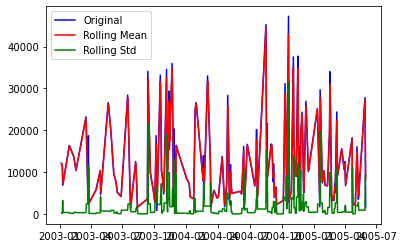

Results of Dickey-Fuller Test:
ADF Statistic: -7.346864
p-value: 0.000000
Critical Values:
1% -3.4378800537375045
5% -2.864864011317803
10% -2.5685399483682003
timeserire is stationary

statistics for Trucks and Buses


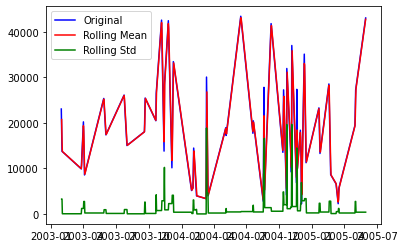

Results of Dickey-Fuller Test:
ADF Statistic: -2.939843
p-value: 0.040907
Critical Values:
1% -3.4381774989729816
5% -2.8649951426291
10% -2.568609799556849
timeserire is stationary

statistics for Classic Cars


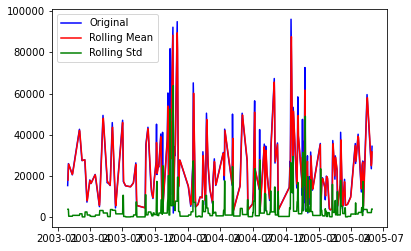

Results of Dickey-Fuller Test:
ADF Statistic: -6.980574
p-value: 0.000000
Critical Values:
1% -3.438168140637663
5% -2.864991017121922
10% -2.5686076019468094
timeserire is stationary

statistics for Motorcycles


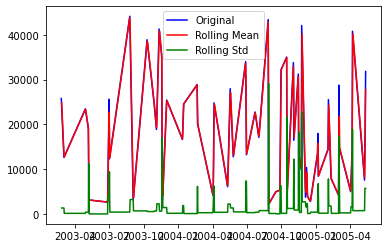

Results of Dickey-Fuller Test:
ADF Statistic: -4.999602
p-value: 0.000022
Critical Values:
1% -3.4385402373395473
5% -2.8651550415718114
10% -2.5686949773613197
timeserire is stationary

statistics for Planes


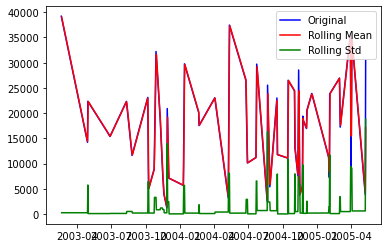

Results of Dickey-Fuller Test:
ADF Statistic: -5.381949
p-value: 0.000004
Critical Values:
1% -3.4384389256151358
5% -2.8651103842072048
10% -2.568671188193778
timeserire is stationary

statistics for Ships


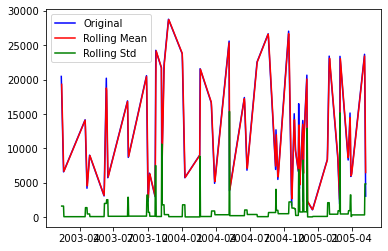

Results of Dickey-Fuller Test:
ADF Statistic: -5.036367
p-value: 0.000019
Critical Values:
1% -3.4383892038884722
5% -2.8650884667384955
10% -2.568659512747501
timeserire is stationary

statistics for Trains


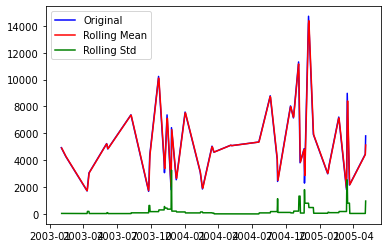

Results of Dickey-Fuller Test:
ADF Statistic: -5.041986
p-value: 0.000018
Critical Values:
1% -3.4384090190455994
5% -2.865097201355259
10% -2.5686641656756155
timeserire is stationary


In [ ]:
# Function to test the stationarity
def test_stationarity(timeseries):
    
    # Determing rolling statistics
    roll_mean = timeseries.rolling(2).mean()
    roll_std = timeseries.rolling(2).std()
# Plotting rolling statistics:
    orig = plt.plot(timeseries.resample('D').mean(), color='blue',label='Original')
    mean = plt.plot(roll_mean.resample('D').mean(), color='red', label='Rolling Mean')
    std = plt.plot(roll_std.resample('D').mean(), color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show(block=False)
    
  # Performing Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
           print(key, value)
    if result[1] < 0.05:
        print('timeserire is stationary')
    else:
        print('timeserire is not stationary')
# Testing stationarity of store type a

for product in products_list:
    print('\nstatistics for '+ product)
    test_stationarity(prods_dic[product])
    

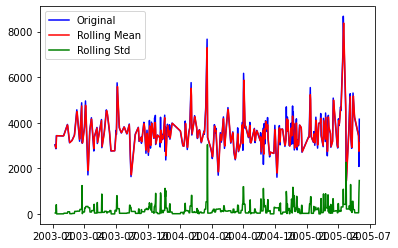

Results of Dickey-Fuller Test:
ADF Statistic: -9.903887
p-value: 0.000000
Critical Values:
1% -3.437854130362047
5% -2.8648525821630173
10% -2.5685338603647714
timeserire is stationary


In [ ]:
test_stationarity(full_time)

As we can see, the time series is stationary. Now we can perform ARIMA model for forecasting.

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [ ]:

# Determing p,d,q combinations with AIC scores.
def best_AIC(df):
    aic_res = []
    seasonal_param_res = []
    parameters_res = []
    for parameters in pdq:
        for seasonal_param in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order=parameters,
                                                seasonal_param_order=seasonal_param,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                #print('SARIMA{}x{}12 - AIC:{}'.format(parameters, seasonal_param, results.aic))
                aic_res.append(results.aic)
                seasonal_param_res.append(seasonal_param)
                parameters_res.append(parameters)
            except:
                continue
            
    #print(min(aic_res))
    seas_param = seasonal_param_res[-1]
    #print(seas_param)
    params = parameters_res[-1]
    #print(params)
    return seas_param, params

print(best_AIC(all_products))


((1, 1, 1, 12), (1, 1, 1))


In [ ]:
def creat_res_sum(df):
    seas_param = best_AIC(df)[0]
    params = best_AIC(df)[1]
    mod = sm.tsa.statespace.SARIMAX(df,
                                    order=params,
                                    seasonal_order=seas_param,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    return results
creat_res_sum(all_products)
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8428      0.011     74.620      0.000       0.821       0.865
ma.L1         -0.9945      0.006   -170.598      0.000      -1.006      -0.983
ar.S.L12      -0.0505      0.040     -1.254      0.210      -0.129       0.028
ma.S.L12      -0.9721      0.020    -48.343      0.000      -1.011      -0.933
sigma2      1.579e+05   3232.551     48.836      0.000    1.52e+05    1.64e+05


C:\Users\ofirr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


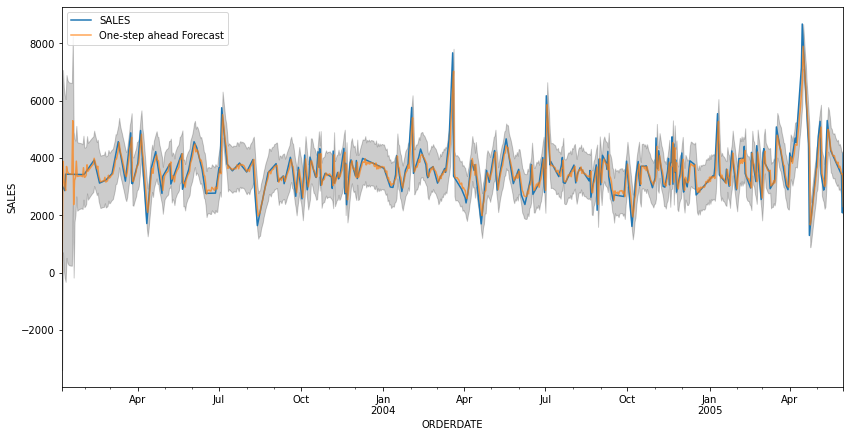

The Mean Squared Error of the forecasts is 416.63
sales prediction for the next 7 days is:
2005-06-01    4082.957321
2005-06-02    4099.379677
2005-06-03    4051.897440
2005-06-04    4037.889896
2005-06-05    4015.774824
2005-06-06    4110.444719
2005-06-07    4018.632942
Freq: D, Name: predicted_mean, dtype: float64


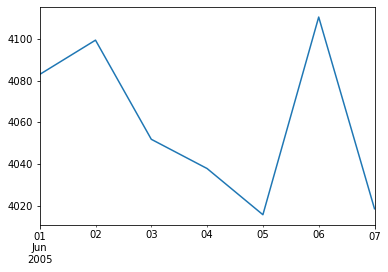

In [ ]:
def pred_plot(df):
    results = creat_res_sum(df)
    pred = results.get_prediction(start=df.first_valid_index(), dynamic=False)
    pred_val = pred.conf_int()
    ax = df['2002':].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_val.index,
                    pred_val.iloc[:, 0],
                    pred_val.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('ORDERDATE')
    ax.set_ylabel('SALES')
    plt.legend()
    plt.show()
    
    y_forecasted = pred.predicted_mean
    y_truth = df['SALES']

    from sklearn.metrics import mean_squared_error
    from math import sqrt

    mse = mean_squared_error(y_forecasted, y_truth)
    rmse = sqrt(mse)
    print('The Mean Squared Error of the forecasts is {}'.format(round(rmse, 2)))
    
    print('sales prediction for the next 7 days is:')
    results = creat_res_sum(df)
    forecast = results.forecast(steps=7)
    print(forecast)
    forecast.plot()
    

pred_plot(all_products)

After we performed the analysis regarding all the products, now we will do the same for each product separately.

prediction for Vintage Cars


C:\Users\ofirr\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ofirr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


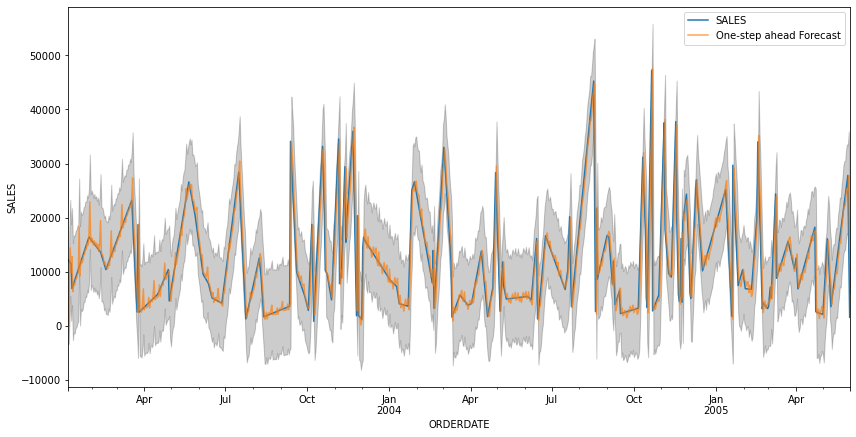

The Mean Squared Error of the forecasts is 4198.54
sales prediction for the next 7 days is:


C:\Users\ofirr\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2005-06-01    1992.916370
2005-06-02     972.681762
2005-06-03    1115.115940
2005-06-04    1579.318918
2005-06-05    2878.931692
2005-06-06    3691.916971
2005-06-07    3285.046360
Freq: D, Name: predicted_mean, dtype: float64
prediction for Trucks and Buses


C:\Users\ofirr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


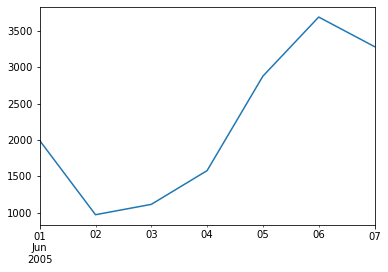

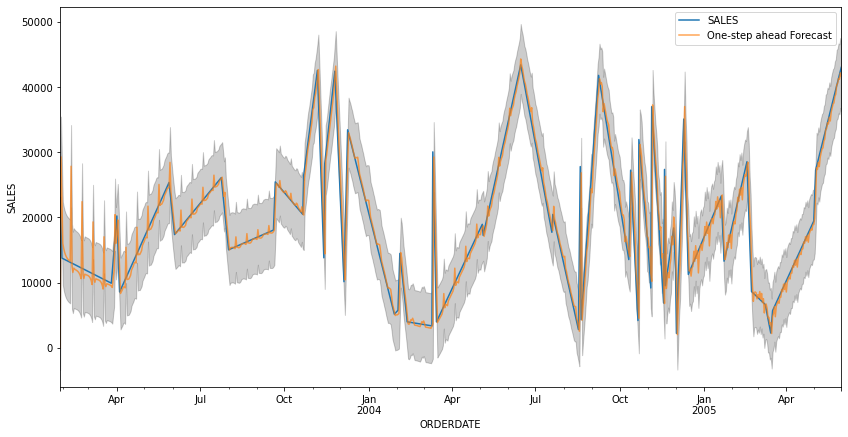

The Mean Squared Error of the forecasts is 2949.56
sales prediction for the next 7 days is:
2005-06-01    42981.579480
2005-06-02    43048.344302
2005-06-03    43151.206916
2005-06-04    42912.886845
2005-06-05    43071.127040
2005-06-06    43039.056891
2005-06-07    43797.170246
Freq: D, Name: predicted_mean, dtype: float64
prediction for Classic Cars


C:\Users\ofirr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


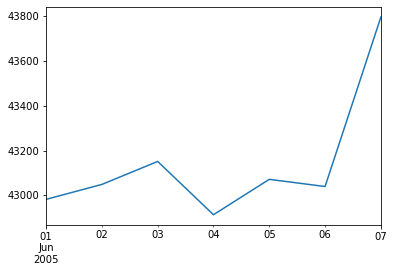

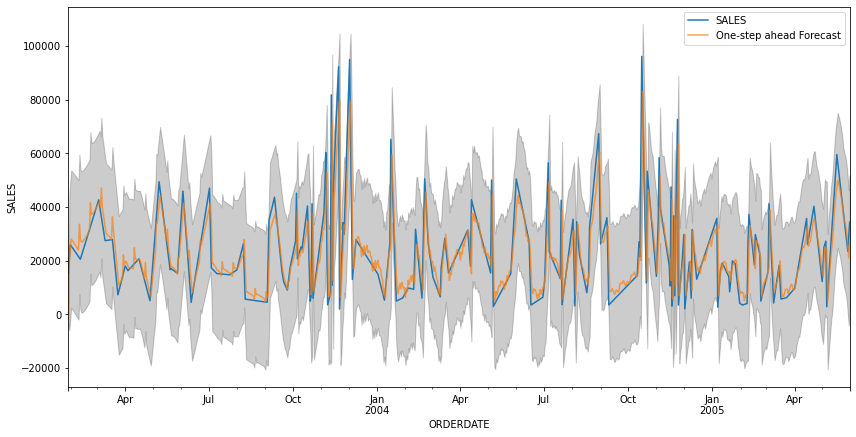

The Mean Squared Error of the forecasts is 8916.57
sales prediction for the next 7 days is:
2005-06-01    31971.835658
2005-06-02    30613.479616
2005-06-03    29832.011747
2005-06-04    29249.764429
2005-06-05    27393.184913
2005-06-06    26413.060530
2005-06-07    26699.240633
Freq: D, Name: predicted_mean, dtype: float64
prediction for Motorcycles


C:\Users\ofirr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


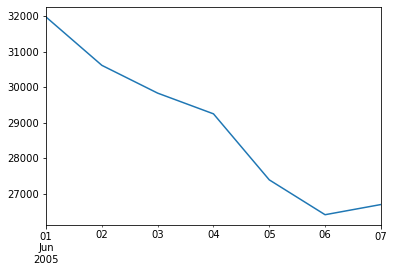

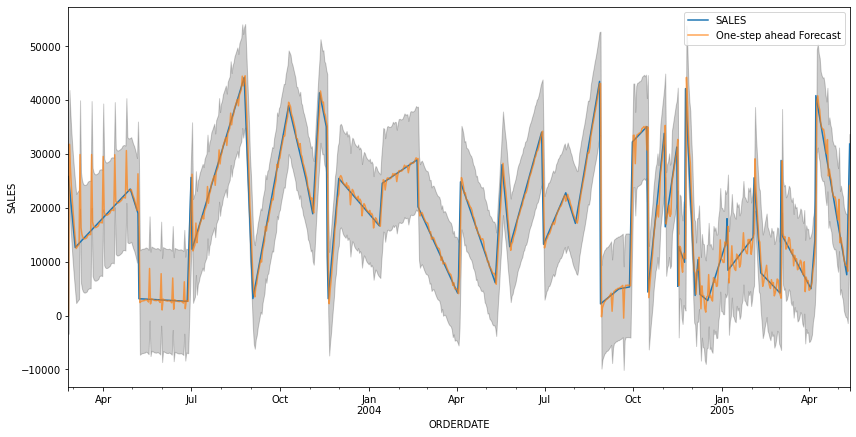

The Mean Squared Error of the forecasts is 3786.56
sales prediction for the next 7 days is:
2005-05-14    36585.936282
2005-05-15    35232.116058
2005-05-16    35324.981429
2005-05-17    35070.482218
2005-05-18    35005.680298
2005-05-19    34071.214233
2005-05-20    33337.872693
Freq: D, Name: predicted_mean, dtype: float64
prediction for Planes


C:\Users\ofirr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


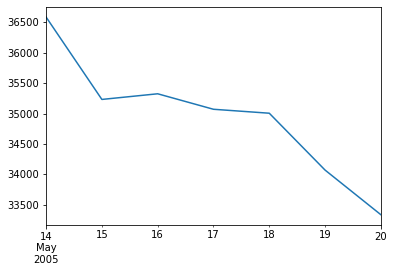

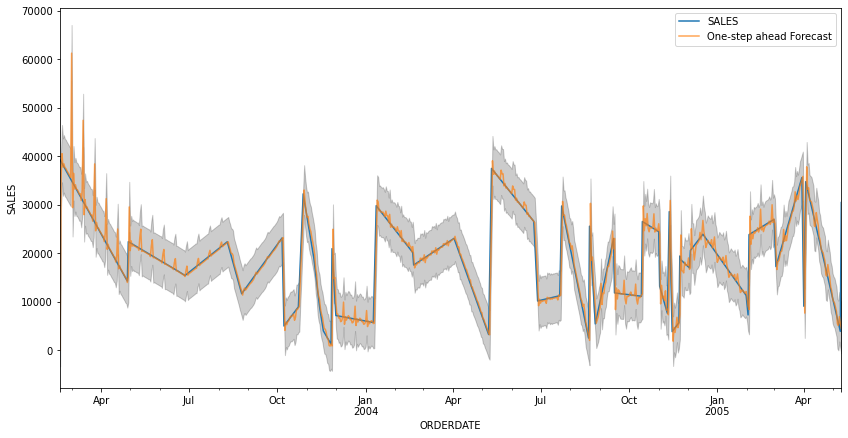

The Mean Squared Error of the forecasts is 3181.08
sales prediction for the next 7 days is:
2005-05-11    35966.568344
2005-05-12    33963.823302
2005-05-13    33666.662878
2005-05-14    32743.193727
2005-05-15    32546.700019
2005-05-16    32295.740014
2005-05-17    32063.216203
Freq: D, Name: predicted_mean, dtype: float64
prediction for Ships


C:\Users\ofirr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


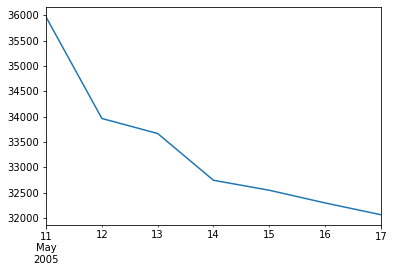

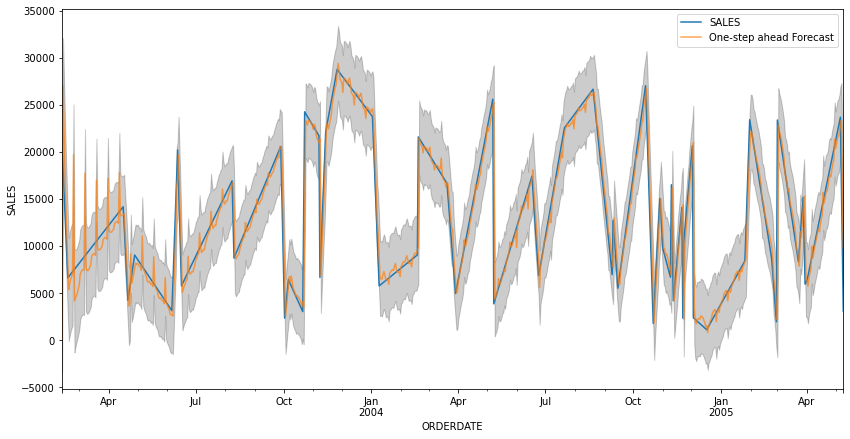

The Mean Squared Error of the forecasts is 2290.8
sales prediction for the next 7 days is:
2005-05-10    3203.580045
2005-05-11    3292.408658
2005-05-12    4951.788504
2005-05-13    5255.164948
2005-05-14    5602.946080
2005-05-15    6072.331539
2005-05-16    6202.487959
Freq: D, Name: predicted_mean, dtype: float64
prediction for Trains


C:\Users\ofirr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


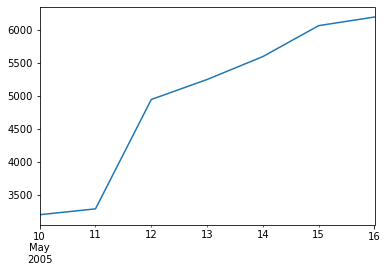

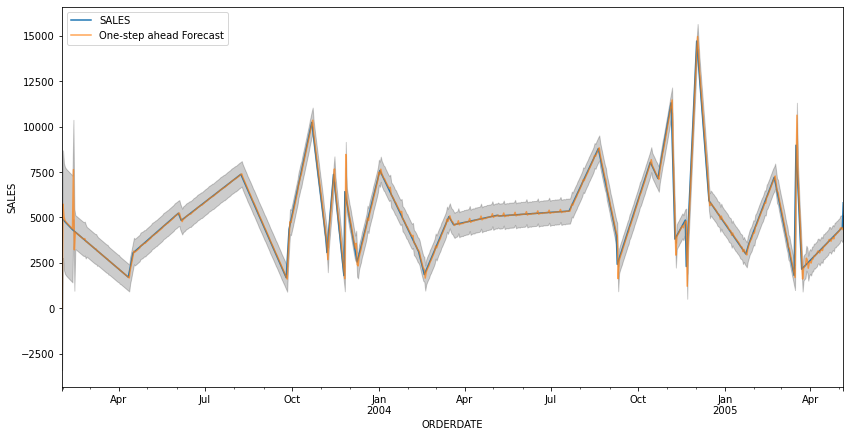

The Mean Squared Error of the forecasts is 406.37
sales prediction for the next 7 days is:
2005-05-07    6444.347712
2005-05-08    6638.120766
2005-05-09    6774.021935
2005-05-10    6829.165133
2005-05-11    6873.520656
2005-05-12    6891.859322
2005-05-13    6914.923951
Freq: D, Name: predicted_mean, dtype: float64


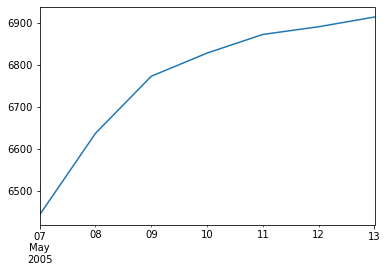

In [ ]:
for product in products_list:
    print('prediction for '+ product)
    pred_plot(prods_dic[product])